# Workplace

## Data Preprocessing

### Imputation below:

1. Filled all missing data of user-ages with `median` and user-country with `mode`.
2. Adjust age less than 10 and greater than 99.
    - Handled the data with semantic error

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

books_df = pd.read_csv('BX-Users.csv')
print(books_df['User-Age'].isnull().sum())
# Remove non-digit characters from 'User-Age' column
books_df['User-Age'] = books_df['User-Age'].str.replace(r'\D', '', regex=True)

# Convert 'User-Age' column to numeric
books_df['User-Age'] = pd.to_numeric(books_df['User-Age'], errors='coerce')

# Compute the median age
median_age = books_df['User-Age'].median()
print(median_age)

# Replace NaN values with the median
books_df['User-Age'] = books_df['User-Age'].fillna(median_age)

# Adjusting ages greater than 99 and less than 10
books_df.loc[books_df['User-Age'] > 210, 'User-Age'] = books_df['User-Age'] - 200
books_df.loc[books_df['User-Age'] >= 200, 'User-Age'] = books_df['User-Age'] - 200 + 10
books_df.loc[books_df['User-Age'] > 110, 'User-Age'] = books_df['User-Age'] - 100
books_df.loc[books_df['User-Age'] >= 100, 'User-Age'] = books_df['User-Age'] - 100 + 10
books_df.loc[books_df['User-Age'] < 10, 'User-Age'] = books_df['User-Age'] + 10

18952
34.0


In [36]:
# Compute the mode country
mode_country = books_df['User-Country'].mode()[0]

# Replace NaN values with the mode
books_df['User-Country'] = books_df['User-Country'].fillna(mode_country)

Check the distribution of raw data, draft below

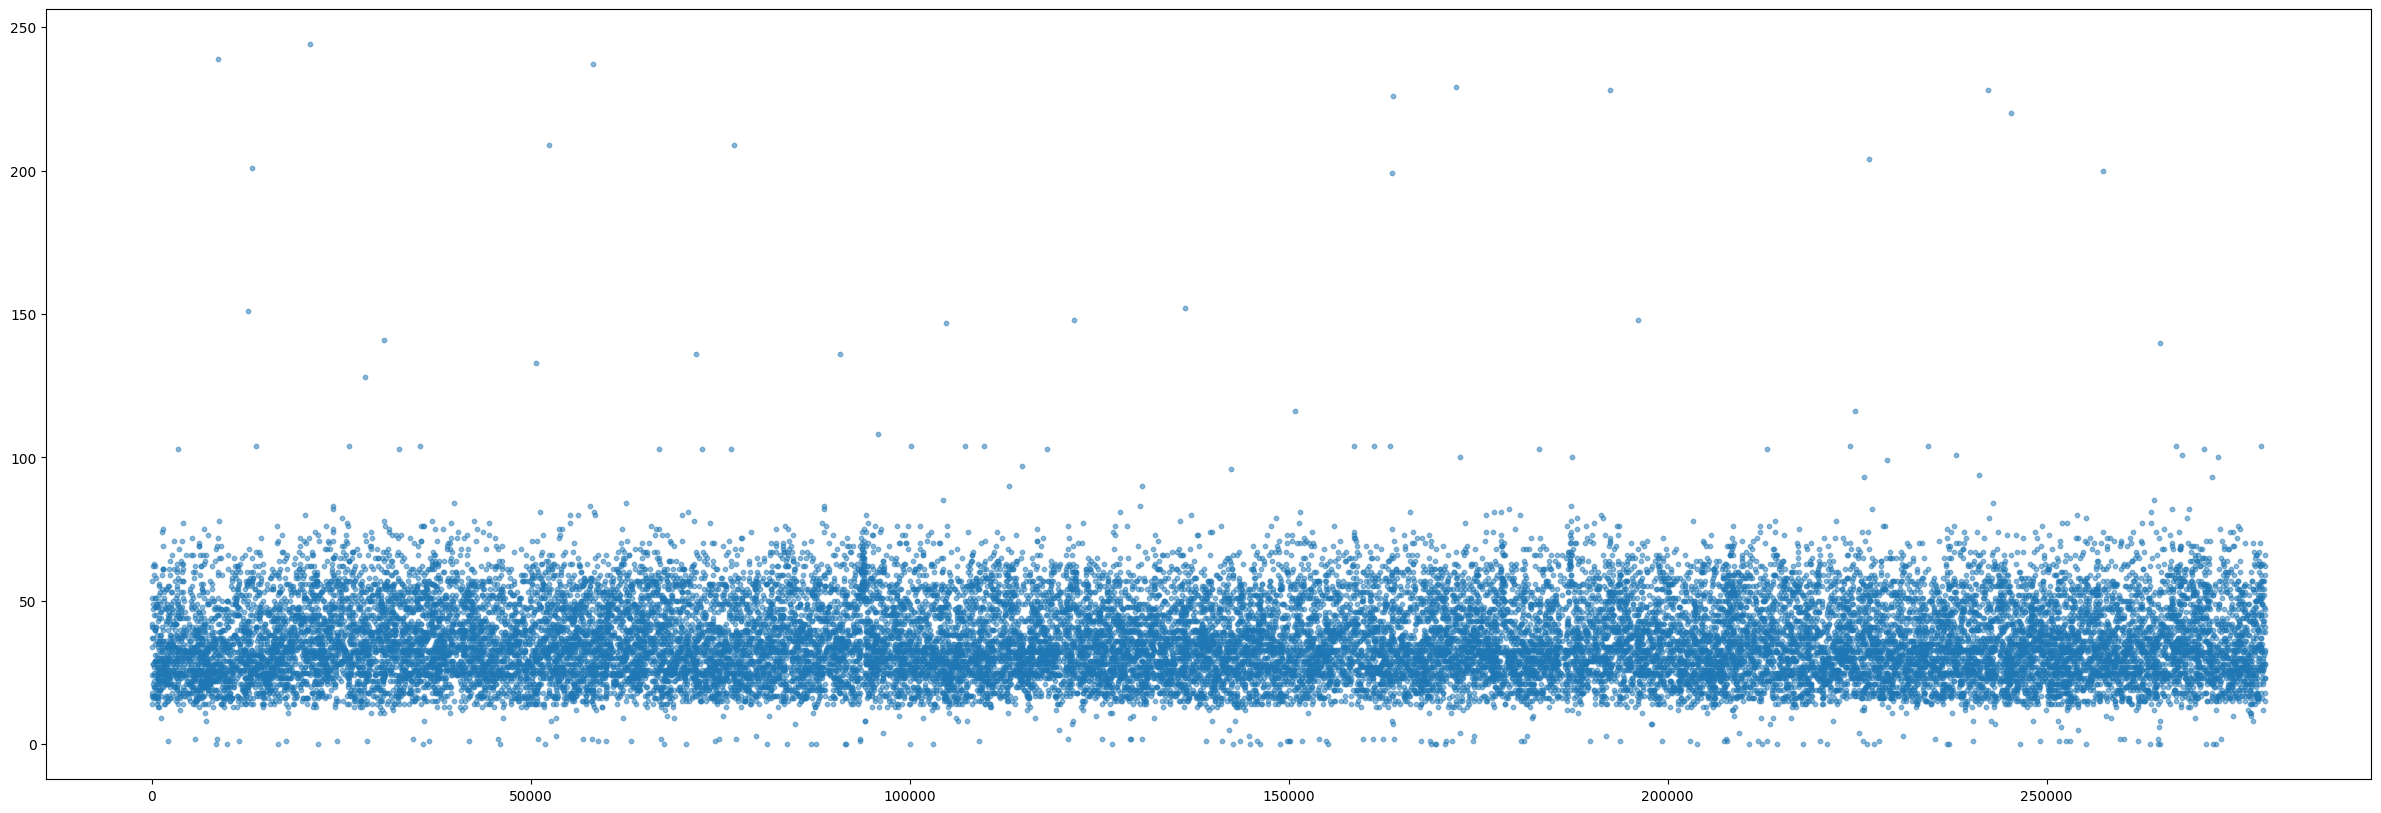

In [43]:
books_cp = pd.read_csv("BX-Users.csv")

# Remove non-digit characters from 'User-Age' column
books_cp["User-Age"] = books_cp["User-Age"].str.replace(r"\D", "", regex=True)

# Convert 'User-Age' column to numeric
books_cp["User-Age"] = pd.to_numeric(books_cp["User-Age"], errors="coerce")


plt.figure(figsize=(30, 10))
plt.scatter(x=books_cp["User-ID"] ,
            y=books_cp["User-Age"],
            s=10,
            alpha=0.5)
plt.show()